# Proyecto final - Minería de Datos
### Alejandro Carregha, Eduardo Don Pablo y José Salvador Abascal

## Descripción del Dataset

Una compañía de seguros médicos ha puesto a disposición un conjunto de datos que reúne información de aproximadamente 1,000 clientes. El objetivo principal de este dataset es permitir el desarrollo de un modelo predictivo capaz de estimar el costo anual del seguro médico (Price Premium of the insurance in USD) para cada cliente.

Es importante destacar que los datos han sido proporcionados de manera voluntaria por los clientes, lo que significa que la información reflejada en el conjunto es representativa de personas reales y sus condiciones de salud, permitiendo realizar análisis confiables y útiles para el diseño de modelos de riesgo, segmentación de clientes y optimización de precios.

### Variables del dataset:
- **Age**: Edad del cliente. Representa un factor crucial para las aseguradoras, ya que el riesgo médico suele aumentar con la edad.
- **Diabetes:**: Indica si la persona presenta niveles anormales de azúcar en la sangre. Este factor incrementa el riesgo y suele influir en un costo mayor del seguro debido a posibles complicaciones médicas.
- **BloodPressureProblems**: Señala si el individuo tiene problemas de presión arterial. La hipertensión es un factor de riesgo importante y comúnmente asociado a tratamientos médicos frecuentes.
- **AnyTransplants**: Indica si el cliente ha pasado por un trasplante de órgano mayor. Este tipo de procedimientos implica un historial médico de alto riesgo y puede incrementar significativamente el costo de la póliza.
- **AnyChronicDiseases**: Indica si el cliente padece alguna enfermedad crónica como asma, artritis, entre otras. Las condiciones crónicas suelen requerir tratamientos continuos, lo que impacta el cálculo del seguro.
- **Height**: Altura del cliente. Se usa principalmente junto con el peso para calcular indicadores como el índice de masa corporal (IMC), útil para identificar riesgo relacionado con sobrepeso u obesidad.
- **Weight**: Peso del cliente. Contribuye a estimar la condición física del individuo y evaluar riesgos asociados a hábitos de salud y posibles enfermedades.
- **KnownAllergies**: Señala si el cliente tiene alergias conocidas. Esto puede incluir alergias alimentarias, a medicamentos o ambientales, y aunque no siempre implica un alto riesgo, sí puede influir en el precio dependiendo de la severidad.
- **HistoryOfCancerInFamily**: Indica si algún familiar directo del cliente ha tenido algún tipo de cáncer. Un historial familiar positivo puede elevar la probabilidad de enfermedades hereditarias, lo cual es relevante para modelos de riesgo.
- **NumberOfMajorSurgeries**: Número de cirugías mayores que el cliente ha tenido. Un historial quirúrgico amplio suele estar asociado con mayores costos médicos y seguimiento especializado.

##### Variable objetivo:
- **PriceUSD**: Es la variable objetivo del dataset. Representa el precio anual del seguro médico en dólares estadounidenses para cada cliente, calculado en función de las variables anteriores.

### 1. Importar datos:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Descargar y leer el dataset
data = pd.read_csv("Medicalpremium.csv")

print("Dataset cargado exitosamente!")
print(f"Dimensiones del dataset: {data.shape}")
print(f"Columnas: {data.columns.tolist()}")

Dataset cargado exitosamente!
Dimensiones del dataset: (986, 11)
Columnas: ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice']


### 2. Análisis exploratorio de datos (EDA):

In [3]:
# Cambio de moneda (rupias a dólares)
data['PriceUSD'] = data['PremiumPrice']*0.011
del data['PremiumPrice']

# Primeras filas del dataset
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PriceUSD
0,45,0,0,0,0,155,57,0,0,0,275.0
1,60,1,0,0,0,180,73,0,0,0,319.0
2,36,1,1,0,0,158,59,0,0,1,253.0
3,52,1,1,0,1,183,93,0,0,2,308.0
4,38,0,0,0,1,166,88,0,0,1,253.0


In [4]:
# Información general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      986 non-null    int64  
 1   Diabetes                 986 non-null    int64  
 2   BloodPressureProblems    986 non-null    int64  
 3   AnyTransplants           986 non-null    int64  
 4   AnyChronicDiseases       986 non-null    int64  
 5   Height                   986 non-null    int64  
 6   Weight                   986 non-null    int64  
 7   KnownAllergies           986 non-null    int64  
 8   HistoryOfCancerInFamily  986 non-null    int64  
 9   NumberOfMajorSurgeries   986 non-null    int64  
 10  PriceUSD                 986 non-null    float64
dtypes: float64(1), int64(10)
memory usage: 84.9 KB


In [5]:
# Estadísticas descriptivas
data.describe().round(2)

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PriceUSD
count,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00
mean,41.75,0.42,0.47,0.06,0.18,168.18,76.95,0.22,0.12,0.67,267.70
std,13.96,0.49,0.50,0.23,0.38,10.10,14.27,0.41,0.32,0.75,68.73
min,18.00,0.00,0.00,0.00,0.00,145.00,51.00,0.00,0.00,0.00,165.00
25%,30.00,0.00,0.00,0.00,0.00,161.00,67.00,0.00,0.00,0.00,231.00
50%,42.00,0.00,0.00,0.00,0.00,168.00,75.00,0.00,0.00,1.00,253.00
75%,53.00,1.00,1.00,0.00,0.00,176.00,87.00,0.00,0.00,1.00,308.00
max,66.00,1.00,1.00,1.00,1.00,188.00,132.00,1.00,1.00,3.00,440.00


In [6]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())

Valores nulos por columna:
Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PriceUSD                   0
dtype: int64


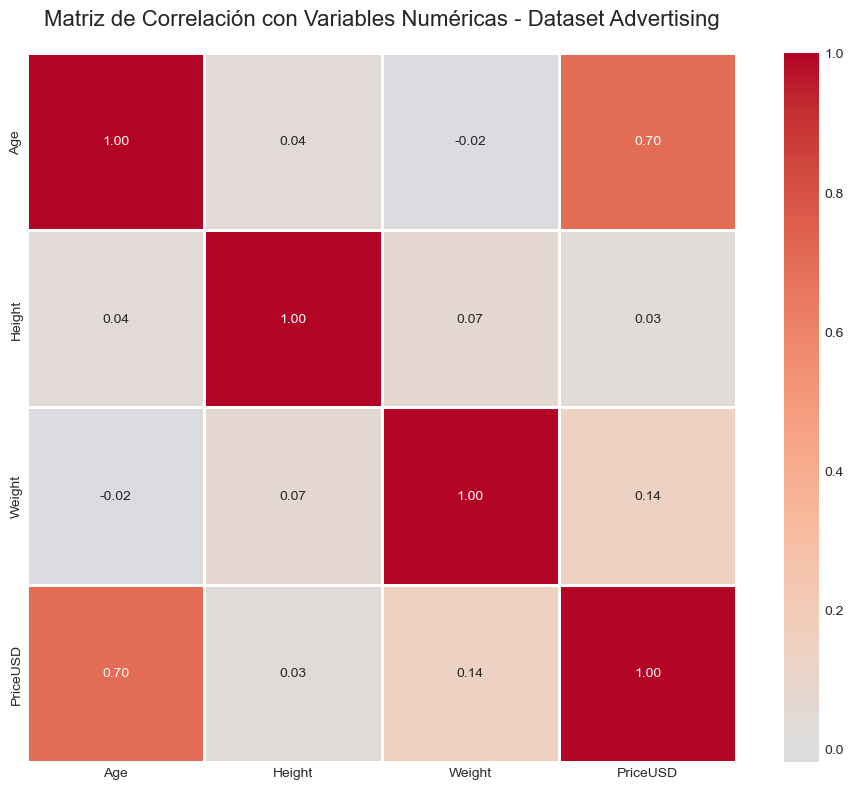

In [7]:
vars_num = data.loc[:,['Age','Height','Weight','PriceUSD']]
# Matriz de correlación con variables numéricas
correlation_matrix = vars_num.corr()
# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Matriz de Correlación con Variables Numéricas - Dataset Advertising', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

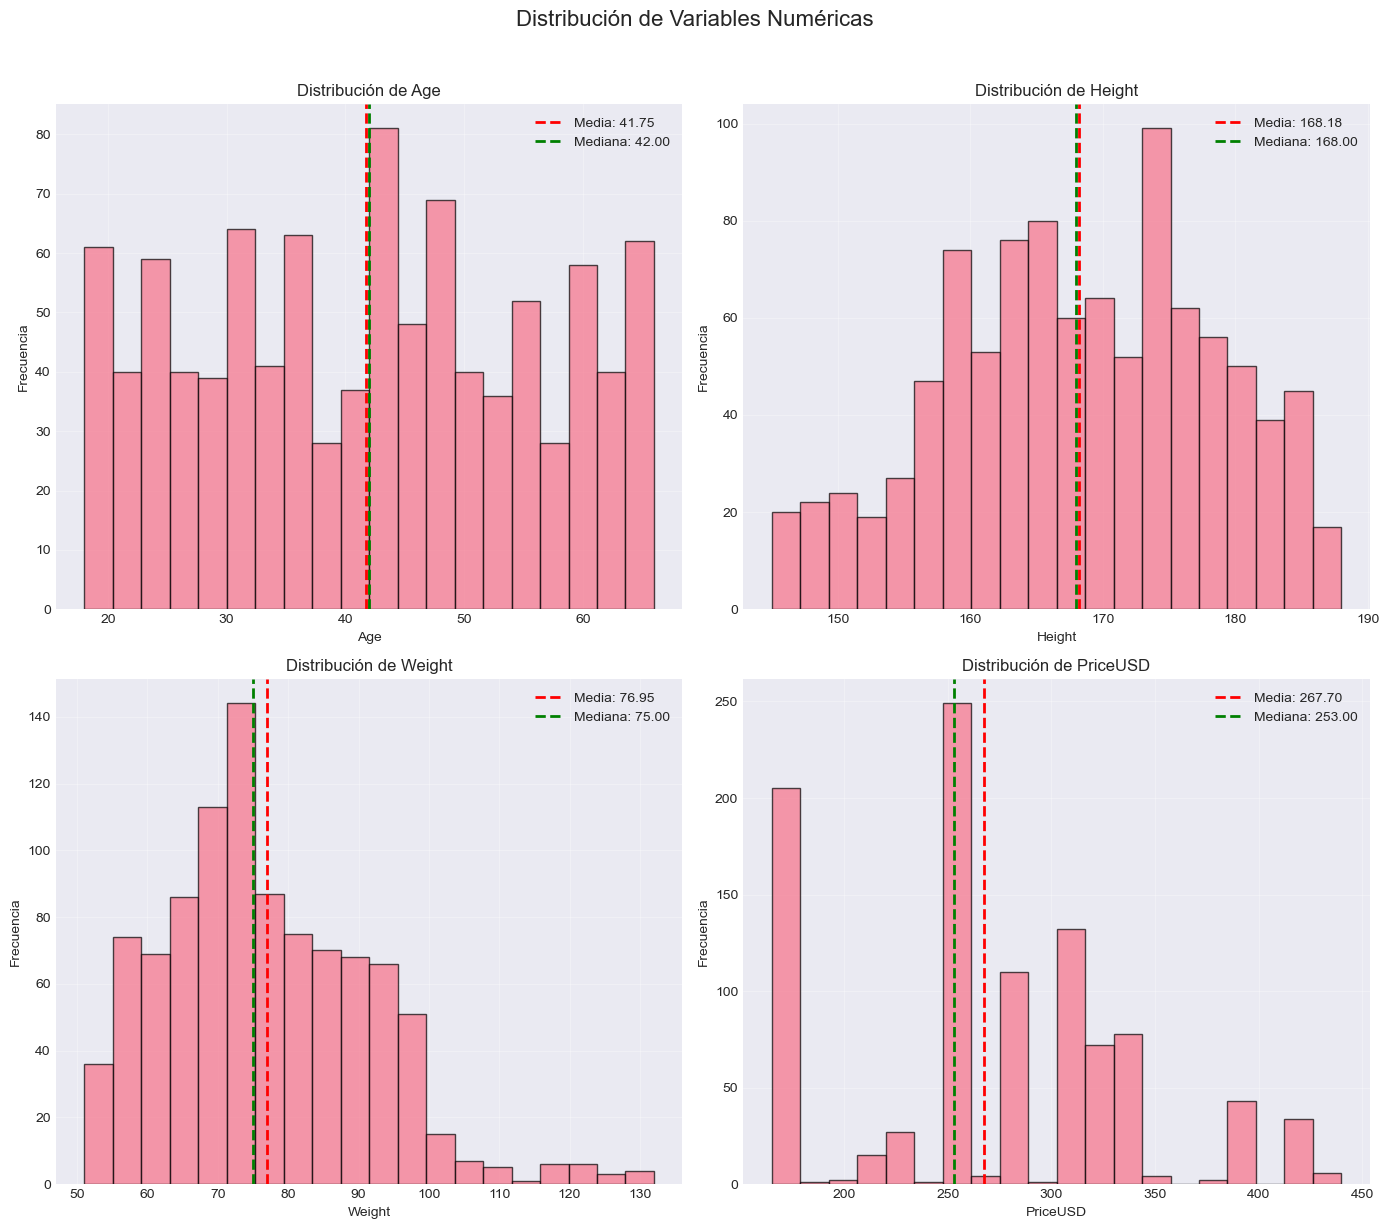

In [8]:
# Distribución de las variables
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Distribución de Variables Numéricas', fontsize=16, y=1.02)

variables = vars_num

for idx, (ax, var) in enumerate(zip(axes.flat, variables)):
    ax.hist(data[var], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribución de {var}', fontsize=12)
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')
    ax.grid(True, alpha=0.3)
    
    # Agregar estadísticas
    mean_val = data[var].mean()
    median_val = data[var].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

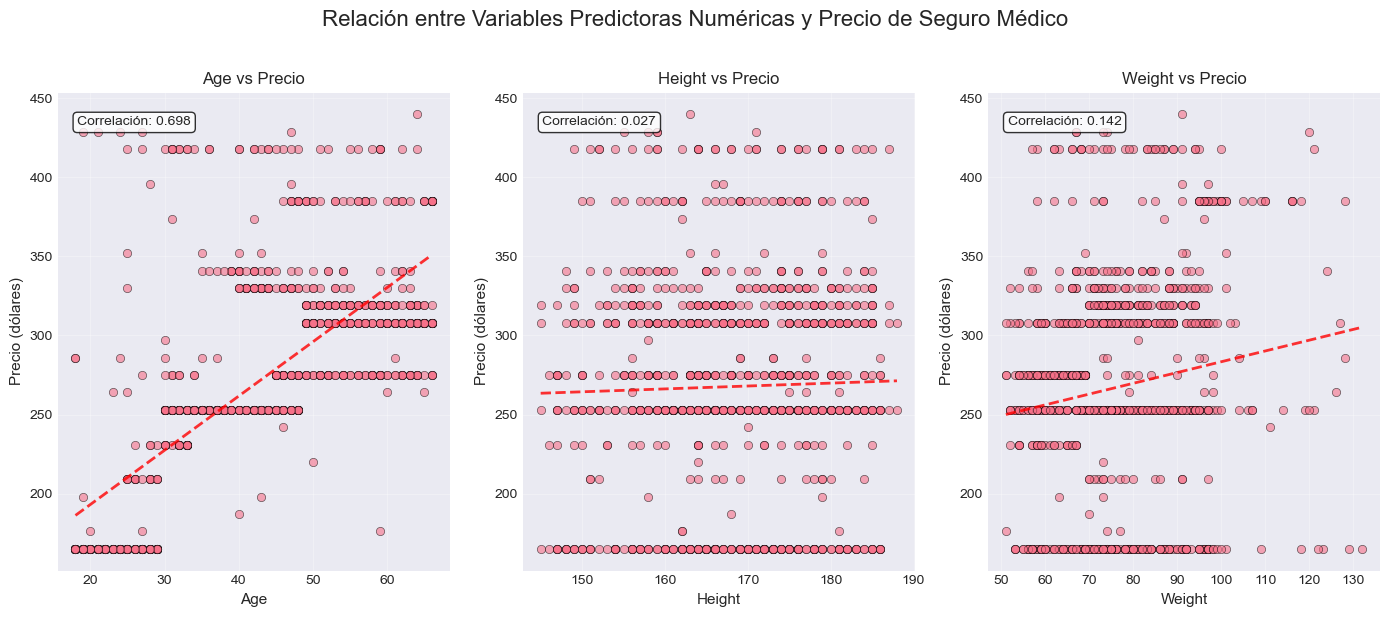

In [9]:
# Relación entre cada variable predictora y las ventas
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Relación entre Variables Predictoras Numéricas y Precio de Seguro Médico', fontsize=16, y=1.02)

predictors = vars_num
axes = axes.flatten()

for ax, predictor in zip(axes, predictors):
    ax.scatter(data[predictor], data['PriceUSD'], alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.set_xlabel(f'{predictor}', fontsize=11)
    ax.set_ylabel('Precio (dólares)', fontsize=11)
    ax.set_title(f'{predictor} vs Precio', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Agregar línea de tendencia
    z = np.polyfit(data[predictor], data['PriceUSD'], 1)
    p = np.poly1d(z)
    ax.plot(data[predictor].sort_values(), p(data[predictor].sort_values()), 
            "r--", alpha=0.8, linewidth=2)
    
    # Agregar correlación
    corr = data[[predictor, 'PriceUSD']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'Correlación: {corr:.3f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

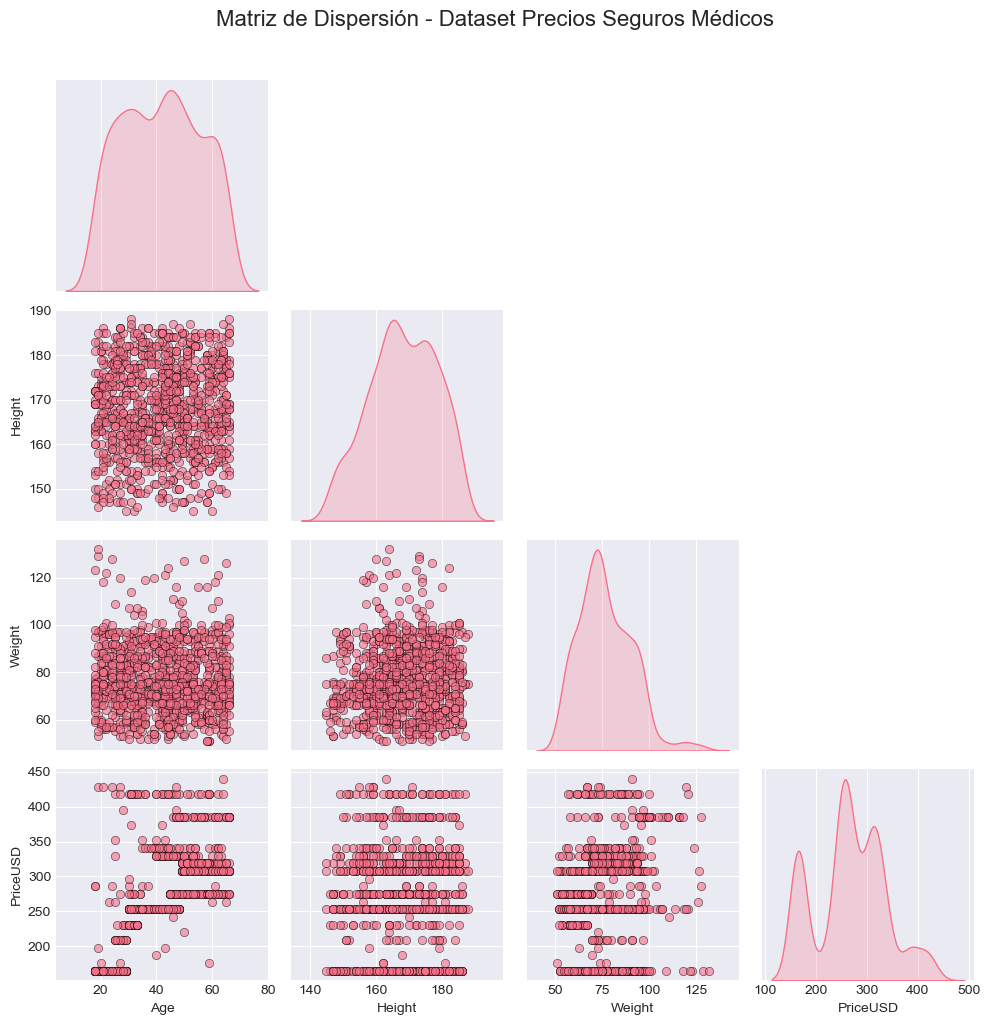

In [10]:
# Pairplot para visualizar todas las relaciones
plt.figure(figsize=(12, 10))
sns.pairplot(vars_num, diag_kind='kde', corner=True, 
             plot_kws={'alpha': 0.6, 'edgecolor': 'black', 'linewidth': 0.5})
plt.suptitle('Matriz de Dispersión - Dataset Precios Seguros Médicos', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [11]:

def calcular_phi_coefficient(serie1, serie2):
    """
    Calcula el coeficiente Phi (φ) entre dos variables categóricas.
    
    El coeficiente Phi es una medida de asociación basada en chi-cuadrado:
    φ = √(χ² / n)
    
    Valores:
    - φ = 0: No hay asociación
    - φ = 1 o -1: Asociación perfecta
    - φ cercano a 0: Asociación débil
    """
    # Eliminar valores nulos
    mask = ~(serie1.isna() | serie2.isna())
    s1 = serie1[mask]
    s2 = serie2[mask]
    
    if len(s1) == 0:
        return 0.0, 1.0  # phi, p-value
    
    # Crear tabla de contingencia
    tabla_contingencia = pd.crosstab(s1, s2)
    
    # Calcular chi-cuadrado
    chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia)
    
    # Calcular Phi
    n = len(s1)
    phi = np.sqrt(chi2 / n)
    
    # Para tablas más grandes que 2x2, ajustar con Cramér's V
    # que es una generalización del coeficiente Phi
    r, k = tabla_contingencia.shape
    if r > 2 or k > 2:
        # Cramér's V
        phi = np.sqrt(chi2 / (n * min(r - 1, k - 1)))
    
    return phi, p_value

def calcular_matriz_phi(df, columnas):
    """
    Calcula la matriz de coeficientes Phi para todas las combinaciones
    de columnas categóricas.
    
    Returns:
        matriz_phi: Matriz de coeficientes Phi
        matriz_pvalues: Matriz de p-values
    """
    n = len(columnas)
    matriz_phi = np.ones((n, n))  # Diagonal es 1
    matriz_pvalues = np.zeros((n, n))
    
    # Calcular para cada par de columnas
    for i, col1 in enumerate(columnas):
        for j, col2 in enumerate(columnas):
            if i != j:
                phi, p_value = calcular_phi_coefficient(df[col1], df[col2])
                matriz_phi[i, j] = phi
                matriz_pvalues[i, j] = p_value
    
    return matriz_phi, matriz_pvalues

def visualizar_phi(matriz_phi, matriz_pvalues, nombres_columnas, alpha=0.05):
    """
    Crea visualizaciones de la matriz de coeficientes Phi.
    """
    # Crear figura con tres subplots
    fig = plt.figure(figsize=(9, 20))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    
    # 1. Heatmap del coeficiente Phi
    sns.heatmap(matriz_phi, 
                annot=True, 
                fmt='.3f', 
                cmap='coolwarm', 
                center=0,
                xticklabels=nombres_columnas,
                yticklabels=nombres_columnas,
                cbar_kws={'label': 'Coeficiente Phi (φ)'},
                ax=ax1,
                vmin=0,
                vmax=1)
    ax1.set_title('Coeficiente Phi (φ)\n(Fuerza de Asociación entre Variables Categóricas)', 
                  fontsize=13, fontweight='bold', pad=15)
    ax1.set_xlabel('Variables', fontsize=11)
    ax1.set_ylabel('Variables', fontsize=11)
    
    # 2. Heatmap de significancia estadística
    # Crear matriz de significancia
    significancia = matriz_pvalues < alpha
    matriz_sig_visual = np.where(significancia, matriz_phi, 0)
    np.fill_diagonal(matriz_sig_visual, 1)
    
    sns.heatmap(matriz_sig_visual, 
                annot=matriz_pvalues, 
                fmt='.4f', 
                cmap='YlGn', 
                xticklabels=nombres_columnas,
                yticklabels=nombres_columnas,
                cbar_kws={'label': 'Phi (solo asociaciones significativas)'},
                ax=ax2,
                vmin=0,
                vmax=1)
    ax2.set_title(f'Significancia Estadística\n(p < {alpha})', 
                  fontsize=13, fontweight='bold', pad=15)
    ax2.set_xlabel('Variables', fontsize=11)
    ax2.set_ylabel('Variables', fontsize=11)
    
    # 3. Gráfico de barras para pares de variables
    pares = []
    valores_phi = []
    valores_p = []
    
    for i in range(len(nombres_columnas)):
        for j in range(i+1, len(nombres_columnas)):
            pares.append(f"{nombres_columnas[i]}\n{nombres_columnas[j]}")
            valores_phi.append(matriz_phi[i, j])
            valores_p.append(matriz_pvalues[i, j])
    
    # Ordenar por valor de Phi
    indices_ordenados = np.argsort(valores_phi)[::-1]
    pares_ordenados = [pares[i] for i in indices_ordenados]
    valores_phi_ordenados = [valores_phi[i] for i in indices_ordenados]
    valores_p_ordenados = [valores_p[i] for i in indices_ordenados]
    
    # Colores según significancia
    colores = ['green' if p < alpha else 'lightcoral' for p in valores_p_ordenados]
    
    barras = ax3.barh(pares_ordenados, valores_phi_ordenados, color=colores, alpha=0.7)
    ax3.set_xlabel('Coeficiente Phi (φ)', fontsize=11)
    ax3.set_title('Asociación entre Pares de Variables Categóricas\n(Verde: p < 0.05, Rojo: p ≥ 0.05)', 
                  fontsize=13, fontweight='bold', pad=15)
    ax3.set_xlim(0, max(valores_phi_ordenados) * 1.15)
    ax3.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for i, (barra, valor_phi, valor_p) in enumerate(zip(barras, valores_phi_ordenados, valores_p_ordenados)):
        ax3.text(valor_phi + 0.01, i, f'{valor_phi:.3f}\n(p={valor_p:.4f})', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def interpretar_phi(phi):
    """
    Interpreta el valor del coeficiente Phi.
    """
    phi_abs = abs(phi)
    if phi_abs < 0.1:
        return "Muy débil o ninguna"
    elif phi_abs < 0.3:
        return "Débil"
    elif phi_abs < 0.5:
        return "Moderada"
    elif phi_abs < 0.7:
        return "Fuerte"
    else:
        return "Muy fuerte"

def analizar_phi_dataset(df, indices_columnas, alpha=0.05):
    """
    Función principal para analizar el dataset con coeficiente Phi.
    
    Args:
        df: DataFrame de pandas con tus datos
        indices_columnas: Lista de índices de columnas (ej: [1, 2, 3, 4, 7, 8])
        alpha: Nivel de significancia para pruebas estadísticas (default: 0.05)
    """
    # Obtener nombres de columnas
    nombres_columnas = [df.columns[i] for i in indices_columnas]
    
    print("="*70)
    print("ANÁLISIS DE COEFICIENTES PHI (φ)")
    print("="*70)
    print(f"\nDataset: {df.shape[0]} filas × {df.shape[1]} columnas")
    print(f"Nivel de significancia: α = {alpha}")
    print(f"\nColumnas analizadas: {', '.join(nombres_columnas)}")
    print("\n" + "-"*70)
    
    # Mostrar información de cada columna
    print("\nInformación de variables categóricas:")
    for idx, col in zip(indices_columnas, nombres_columnas):
        valores_unicos = df.iloc[:, idx].nunique()
        valores_nulos = df.iloc[:, idx].isna().sum()
        categorias = df.iloc[:, idx].value_counts().head(3)
        print(f"\n  • {col}:")
        print(f"    - {valores_unicos} categorías únicas")
        print(f"    - {valores_nulos} valores nulos ({valores_nulos/len(df)*100:.1f}%)")
        print(f"    - Top 3 categorías: {', '.join([f'{idx}: {count}' for idx, count in categorias.items()])}")
    
    # Calcular matrices de Phi y p-values
    print("\n" + "-"*70)
    print("Calculando coeficientes Phi...")
    matriz_phi, matriz_pvalues = calcular_matriz_phi(df, [df.columns[i] for i in indices_columnas])
    
    # Crear DataFrames para mejor visualización
    df_phi = pd.DataFrame(matriz_phi, 
                          index=nombres_columnas, 
                          columns=nombres_columnas)
    
    df_pvalues = pd.DataFrame(matriz_pvalues,
                              index=nombres_columnas,
                              columns=nombres_columnas)
    
    print("\nMatriz de Coeficientes Phi (φ):")
    print(df_phi.round(3))
    
    print("\nMatriz de P-values:")
    print(df_pvalues.round(4))
    
    # Analizar pares de variables
    print("\n" + "-"*70)
    print("ANÁLISIS DETALLADO DE ASOCIACIONES:")
    print("-"*70)
    
    resultados = []
    for i in range(len(nombres_columnas)):
        for j in range(i+1, len(nombres_columnas)):
            phi = matriz_phi[i, j]
            p_val = matriz_pvalues[i, j]
            significativo = "Sí" if p_val < alpha else "No"
            interpretacion = interpretar_phi(phi)
            
            resultados.append({
                'Par': f"{nombres_columnas[i]} - {nombres_columnas[j]}",
                'Phi': phi,
                'P-value': p_val,
                'Significativo': significativo,
                'Interpretación': interpretacion
            })
    
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('Phi', ascending=False)
    
    print(df_resultados.to_string(index=False))
    
    # Resumen
    print("\n" + "="*70)
    print("RESUMEN:")
    print("="*70)
    asociaciones_sig = df_resultados[df_resultados['Significativo'] == 'Sí']
    print(f"\nTotal de pares analizados: {len(df_resultados)}")
    print(f"Asociaciones estadísticamente significativas (p < {alpha}): {len(asociaciones_sig)}")
    
    if len(asociaciones_sig) > 0:
        print(f"\nAsociación MÁS FUERTE:")
        max_row = asociaciones_sig.iloc[0]
        print(f"  {max_row['Par']}")
        print(f"  φ = {max_row['Phi']:.3f} (p = {max_row['P-value']:.4f})")
        print(f"  Interpretación: {max_row['Interpretación']}")
    
    # Crear visualizaciones
    print("\n" + "-"*70)
    print("Generando visualizaciones...")
    visualizar_phi(matriz_phi, matriz_pvalues, nombres_columnas, alpha)
    
    return df_phi, df_pvalues, df_resultados

ANÁLISIS DE COEFICIENTES PHI (φ)

Dataset: 986 filas × 11 columnas
Nivel de significancia: α = 0.05

Columnas analizadas: Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, KnownAllergies, HistoryOfCancerInFamily

----------------------------------------------------------------------

Información de variables categóricas:

  • Diabetes:
    - 2 categorías únicas
    - 0 valores nulos (0.0%)
    - Top 3 categorías: 0: 572, 1: 414

  • BloodPressureProblems:
    - 2 categorías únicas
    - 0 valores nulos (0.0%)
    - Top 3 categorías: 0: 524, 1: 462

  • AnyTransplants:
    - 2 categorías únicas
    - 0 valores nulos (0.0%)
    - Top 3 categorías: 0: 931, 1: 55

  • AnyChronicDiseases:
    - 2 categorías únicas
    - 0 valores nulos (0.0%)
    - Top 3 categorías: 0: 808, 1: 178

  • KnownAllergies:
    - 2 categorías únicas
    - 0 valores nulos (0.0%)
    - Top 3 categorías: 0: 774, 1: 212

  • HistoryOfCancerInFamily:
    - 2 categorías únicas
    - 0 valores nulos (

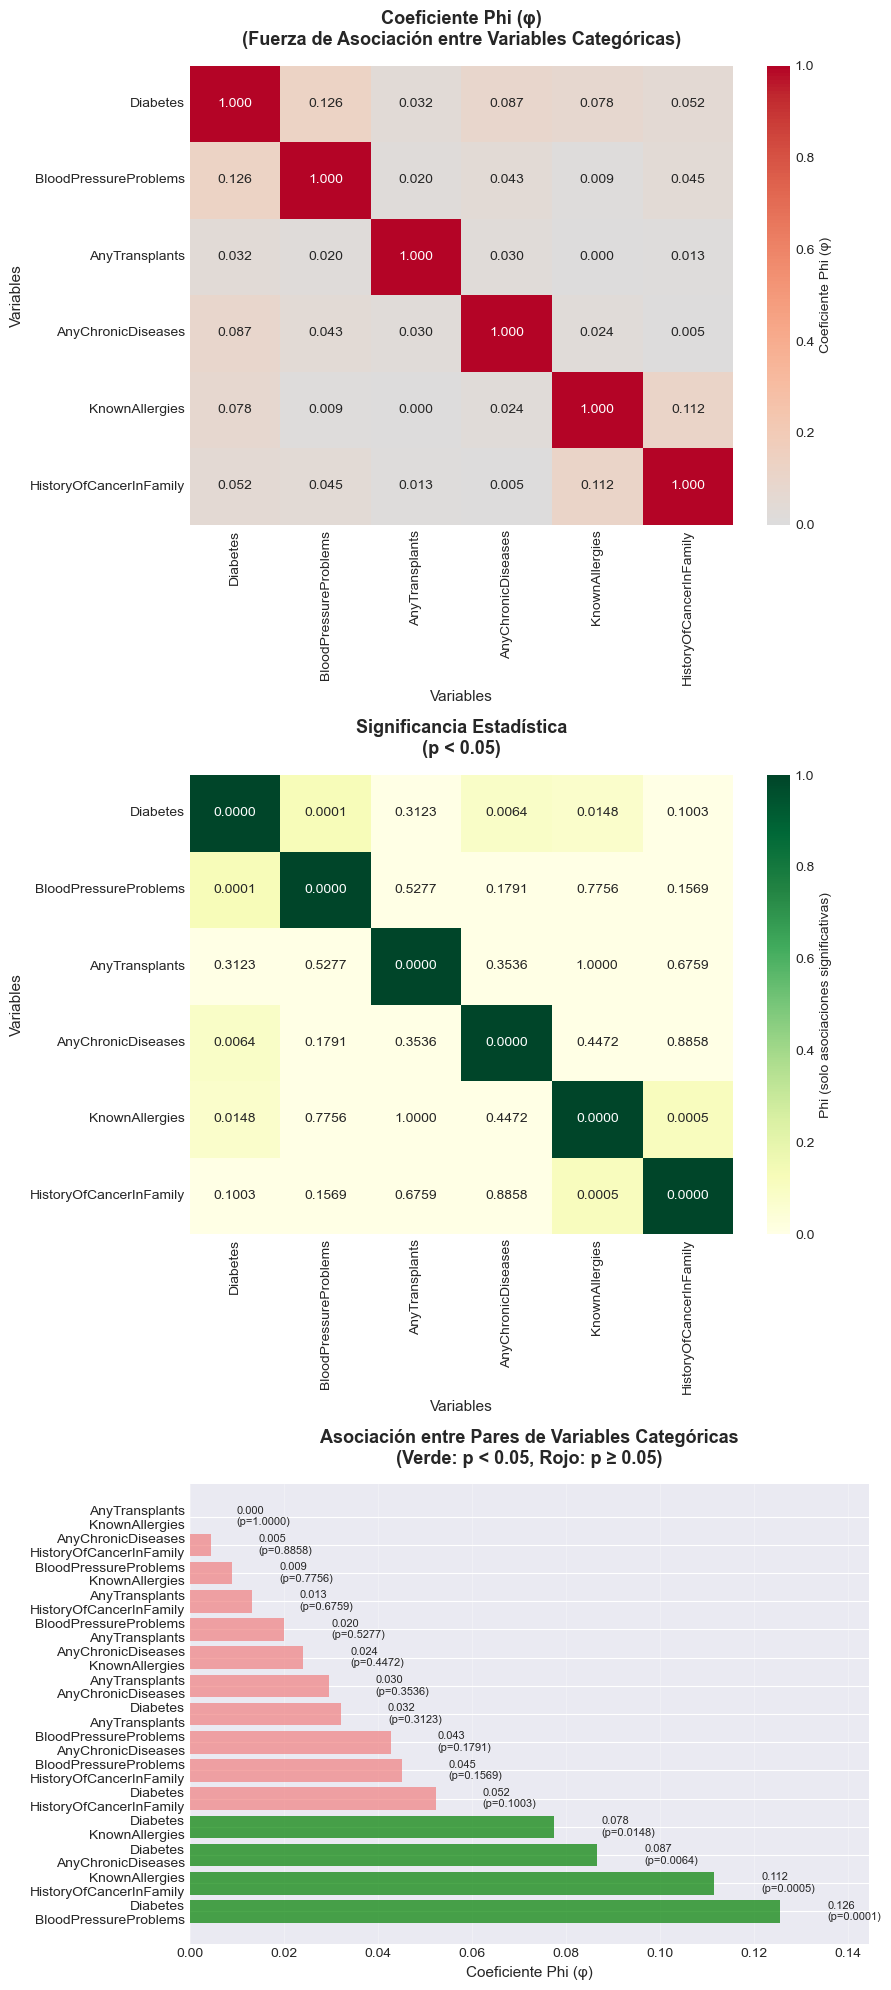

In [12]:
phi_matriz, pvalues_matriz, resultados = analizar_phi_dataset(
    data, 
    indices_columnas=[1, 2, 3, 4, 7, 8],
    alpha=0.05
)

### 3. Modelado con CatBoost - Regresión de Precios de Seguros

In [13]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
import time

# Preparación de datos para el modelado
# Separar features y target
X = data.drop('PriceUSD', axis=1)
y = data['PriceUSD']

print("="*70)
print("PREPARACIÓN DE DATOS PARA CATBOOST")
print("="*70)
print(f"\nDimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"\nVariables predictoras:")
print(f"  • Numéricas: {X.select_dtypes(include=[np.number]).columns.tolist()}")
print(f"  • Categóricas: {X.select_dtypes(include=['object']).columns.tolist()}")
print(f"\nVariable objetivo (PriceUSD):")
print(f"  • Mínimo: ${y.min():.2f}")
print(f"  • Máximo: ${y.max():.2f}")
print(f"  • Media: ${y.mean():.2f}")
print(f"  • Desviación estándar: ${y.std():.2f}")

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDivisión de datos:")
print(f"  • Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")


PREPARACIÓN DE DATOS PARA CATBOOST

Dimensiones de X: (986, 10)
Dimensiones de y: (986,)

Variables predictoras:
  • Numéricas: ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
  • Categóricas: []

Variable objetivo (PriceUSD):
  • Mínimo: $165.00
  • Máximo: $440.00
  • Media: $267.70
  • Desviación estándar: $68.73

División de datos:
  • Conjunto de entrenamiento: 788 muestras (79.9%)
  • Conjunto de prueba: 198 muestras (20.1%)


In [14]:
# Entrenar modelo CatBoost
print("\n" + "="*70)
print("ENTRENAMIENTO DEL MODELO CATBOOST")
print("="*70)

start_time = time.time()

# Crear y entrenar modelo con parámetros optimizados
catboost_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_state=42,
    verbose=False,  # Silenciar output detallado
    use_best_model=True,
    early_stopping_rounds=20
)

catboost_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

training_time = time.time() - start_time

print(f"\n✓ Modelo entrenado exitosamente en {training_time:.2f} segundos")
print(f"\nParámetros principales del modelo:")
print(f"  • Iteraciones: {catboost_model.get_param('iterations')}")
print(f"  • Tasa de aprendizaje: {catboost_model.get_param('learning_rate')}")
print(f"  • Profundidad de árboles: {catboost_model.get_param('depth')}")
print(f"  • Número de árboles entrenados: {catboost_model.tree_count_}")



ENTRENAMIENTO DEL MODELO CATBOOST

✓ Modelo entrenado exitosamente en 0.21 segundos

Parámetros principales del modelo:
  • Iteraciones: 200
  • Tasa de aprendizaje: 0.1
  • Profundidad de árboles: 6
  • Número de árboles entrenados: 117


In [15]:
# Evaluación del modelo
print("\n" + "="*70)
print("EVALUACIÓN DEL MODELO CATBOOST")
print("="*70)

# Predicciones
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)

# Calcular métricas
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Mostrar métricas en formato tabular
print("\nMétricas de Desempeño:")
print("-" * 70)
print(f"{'Métrica':<20} {'Entrenamiento':<20} {'Prueba':<20}")
print("-" * 70)
print(f"{'RMSE (USD)':<20} ${train_rmse:>17.2f}  ${test_rmse:>17.2f}")
print(f"{'MAE (USD)':<20} ${train_mae:>17.2f}  ${test_mae:>17.2f}")
print(f"{'MAPE (%)':<20} {train_mape:>18.2f}%  {test_mape:>18.2f}%")
print(f"{'R² Score':<20} {train_r2:>18.4f}  {test_r2:>18.4f}")
print("-" * 70)

# Análisis de overfitting
print(f"\nAnálisis de Overfitting:")
print(f"  • Diferencia RMSE: ${test_rmse - train_rmse:.2f}")
print(f"  • Diferencia R²: {test_r2 - train_r2:.4f}")

if test_rmse - train_rmse > 500:
    print(f"  ⚠ Posible ligero overfitting detectado")
else:
    print(f"  ✓ Modelo generaliza bien a datos no vistos")

# Resumen interpretativo
print(f"\nInterpretación del Desempeño:")
print(f"  • El modelo explica el {test_r2*100:.2f}% de la varianza en los precios de seguros")
print(f"  • En promedio, el modelo se equivoca en ±${test_mae:.2f} por predicción")
print(f"  • Error relativo promedio del {test_mape:.2f}% respecto al valor real")



EVALUACIÓN DEL MODELO CATBOOST

Métricas de Desempeño:
----------------------------------------------------------------------
Métrica              Entrenamiento        Prueba              
----------------------------------------------------------------------
RMSE (USD)           $            22.69  $            26.50
MAE (USD)            $            13.26  $            17.11
MAPE (%)                           0.05%                0.06%
R² Score                         0.8882              0.8639
----------------------------------------------------------------------

Análisis de Overfitting:
  • Diferencia RMSE: $3.81
  • Diferencia R²: -0.0243
  ✓ Modelo generaliza bien a datos no vistos

Interpretación del Desempeño:
  • El modelo explica el 86.39% de la varianza en los precios de seguros
  • En promedio, el modelo se equivoca en ±$17.11 por predicción
  • Error relativo promedio del 0.06% respecto al valor real



IMPORTANCIA DE CARACTERÍSTICAS

Importancia relativa de cada variable:
----------------------------------------------------------------------
Age                       ██████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░  53.12%
Weight                    ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  12.99%
AnyTransplants            ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  12.77%
AnyChronicDiseases        ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5.52%
NumberOfMajorSurgeries    ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5.09%
Height                    █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   3.83%
HistoryOfCancerInFamily   █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   3.11%
BloodPressureProblems     █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2.66%
KnownAllergies            ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0.56%
Diabetes                  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0.35%


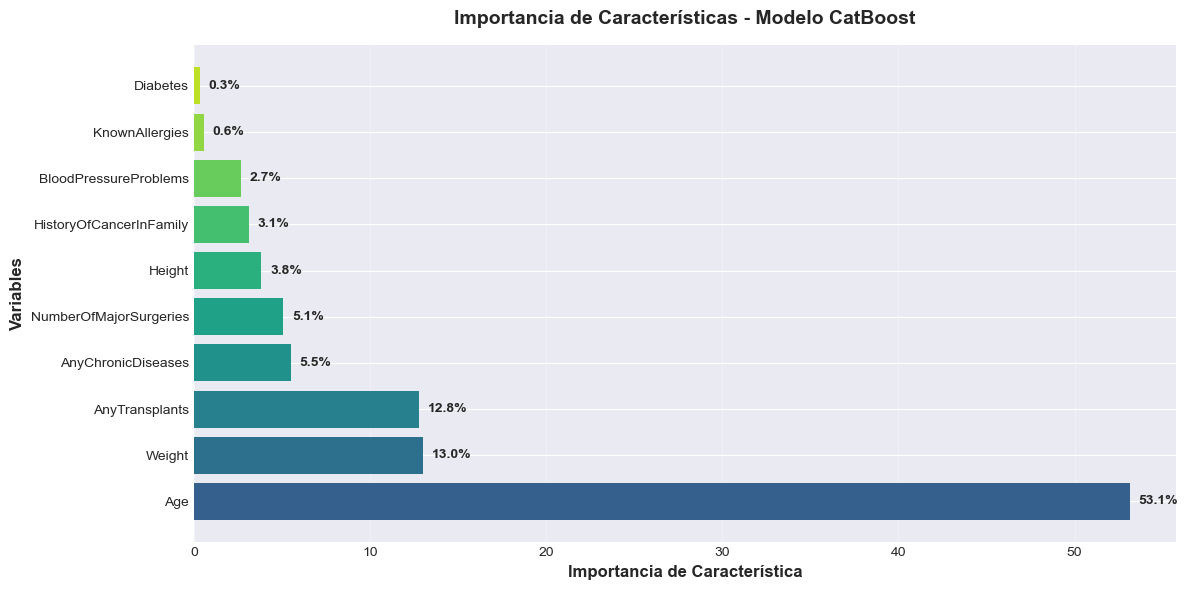


Top 3 características más importantes:
  1. Age: 53.12%
  2. Weight: 12.99%
  3. AnyTransplants: 12.77%


In [16]:
# Análisis de importancia de características
print("\n" + "="*70)
print("IMPORTANCIA DE CARACTERÍSTICAS")
print("="*70)

# Obtener importancia de características
feature_importance = catboost_model.get_feature_importance()
feature_names = X.columns.tolist()

# Crear DataFrame con importancia
df_importance = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': feature_importance
}).sort_values('Importancia', ascending=False)

print("\nImportancia relativa de cada variable:")
print("-" * 70)
for idx, row in df_importance.iterrows():
    pct = (row['Importancia'] / df_importance['Importancia'].sum()) * 100
    bar_length = int(pct / 2)
    bar = "█" * bar_length + "░" * (50 - bar_length)
    print(f"{row['Variable']:<25} {bar} {pct:>6.2f}%")

# Visualización de importancia de características
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_importance)))
barras = ax.barh(df_importance['Variable'], df_importance['Importancia'], color=colors)
ax.set_xlabel('Importancia de Característica', fontsize=12, fontweight='bold')
ax.set_ylabel('Variables', fontsize=12, fontweight='bold')
ax.set_title('Importancia de Características - Modelo CatBoost', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for i, (barra, valor) in enumerate(zip(barras, df_importance['Importancia'])):
    pct = (valor / df_importance['Importancia'].sum()) * 100
    ax.text(valor + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTop 3 características más importantes:")
for idx, (i, row) in enumerate(df_importance.head(3).iterrows(), 1):
    pct = (row['Importancia'] / df_importance['Importancia'].sum()) * 100
    print(f"  {idx}. {row['Variable']}: {pct:.2f}%")



ANÁLISIS DE RESIDUOS Y PREDICCIONES


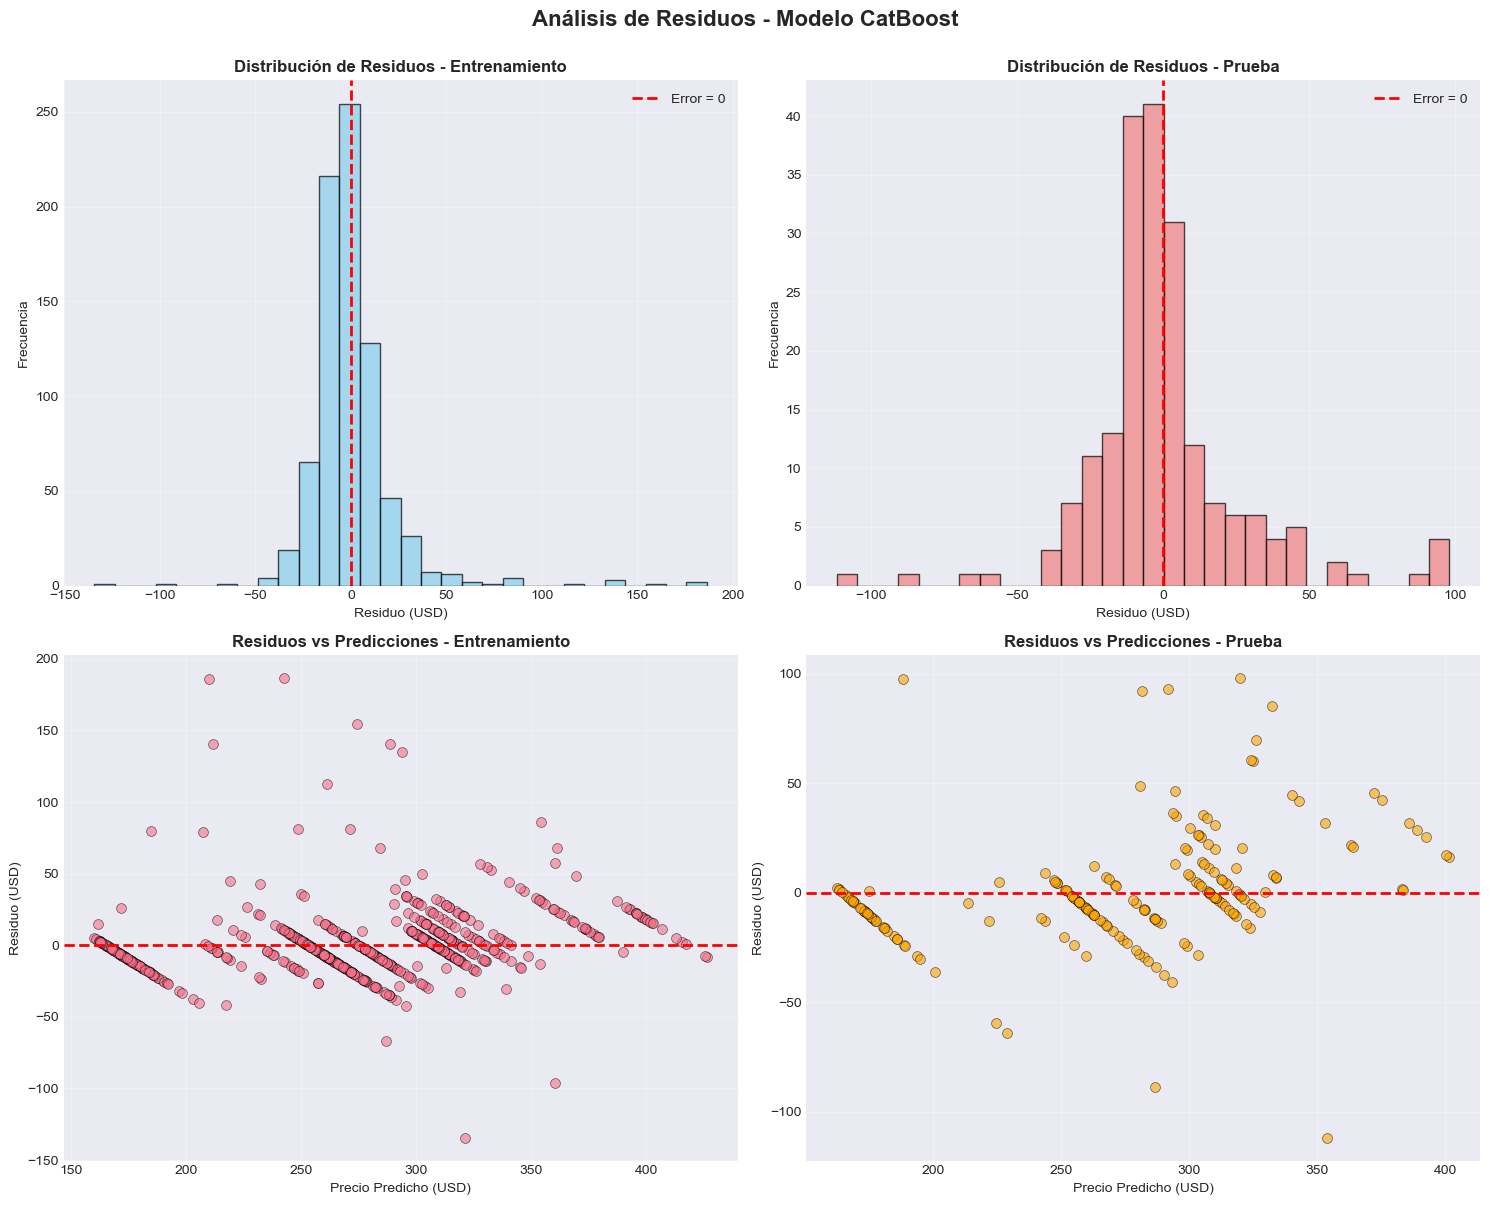


Estadísticas de Residuos:
----------------------------------------------------------------------
Métrica                        Entrenamiento        Prueba              
----------------------------------------------------------------------
Media                          $              0.11  $              0.40
Desv. Estándar                 $             22.71  $             26.57
Mínimo                         $           -134.32  $           -111.70
Máximo                         $            186.45  $             98.01
----------------------------------------------------------------------


In [17]:
# Análisis de residuos
print("\n" + "="*70)
print("ANÁLISIS DE RESIDUOS Y PREDICCIONES")
print("="*70)

# Calcular residuos
residuos_train = y_train - y_train_pred
residuos_test = y_test - y_test_pred

# Crear visualización de residuos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Residuos - Modelo CatBoost', fontsize=16, fontweight='bold', y=1.00)

# 1. Distribución de residuos (Entrenamiento)
axes[0, 0].hist(residuos_train, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[0, 0].set_title('Distribución de Residuos - Entrenamiento', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Residuo (USD)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de residuos (Prueba)
axes[0, 1].hist(residuos_test, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[0, 1].set_title('Distribución de Residuos - Prueba', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residuo (USD)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuos vs Valores Predichos (Entrenamiento)
axes[1, 0].scatter(y_train_pred, residuos_train, alpha=0.6, edgecolors='black', linewidth=0.5, s=50)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuos vs Predicciones - Entrenamiento', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Precio Predicho (USD)')
axes[1, 0].set_ylabel('Residuo (USD)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuos vs Valores Predichos (Prueba)
axes[1, 1].scatter(y_test_pred, residuos_test, alpha=0.6, edgecolors='black', linewidth=0.5, s=50, color='orange')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residuos vs Predicciones - Prueba', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Precio Predicho (USD)')
axes[1, 1].set_ylabel('Residuo (USD)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\nEstadísticas de Residuos:")
print("-" * 70)
print(f"{'Métrica':<30} {'Entrenamiento':<20} {'Prueba':<20}")
print("-" * 70)
print(f"{'Media':<30} ${residuos_train.mean():>18.2f}  ${residuos_test.mean():>18.2f}")
print(f"{'Desv. Estándar':<30} ${residuos_train.std():>18.2f}  ${residuos_test.std():>18.2f}")
print(f"{'Mínimo':<30} ${residuos_train.min():>18.2f}  ${residuos_test.min():>18.2f}")
print(f"{'Máximo':<30} ${residuos_train.max():>18.2f}  ${residuos_test.max():>18.2f}")
print("-" * 70)


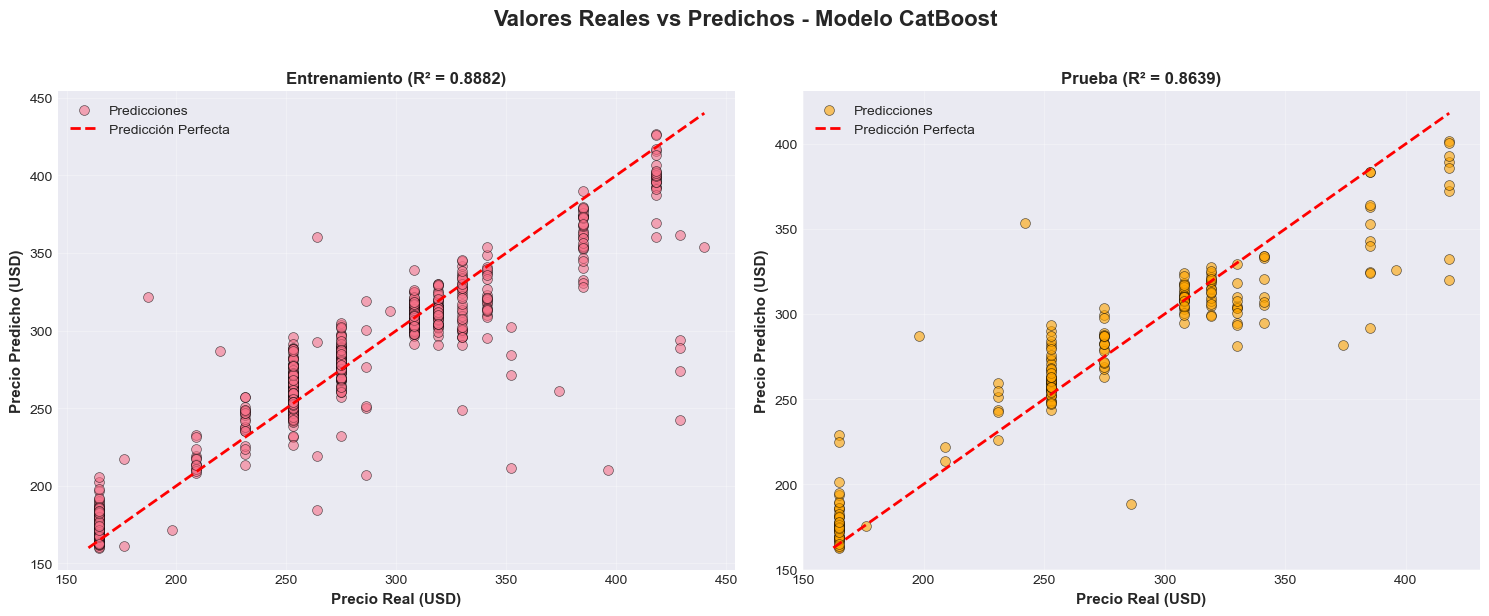

In [18]:
# Gráfico de valores reales vs predichos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Valores Reales vs Predichos - Modelo CatBoost', fontsize=16, fontweight='bold', y=1.02)

# Entrenamiento
axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=50, label='Predicciones')
# Línea de referencia perfecta
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
axes[0].set_xlabel('Precio Real (USD)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Precio Predicho (USD)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Entrenamiento (R² = {train_r2:.4f})', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Prueba
axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=50, color='orange', label='Predicciones')
# Línea de referencia perfecta
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
axes[1].set_xlabel('Precio Real (USD)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precio Predicho (USD)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Prueba (R² = {test_r2:.4f})', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
# Interpretación y conclusiones del modelo
print("\n" + "="*70)
print("INTERPRETACIÓN Y CONCLUSIONES - MODELO CATBOOST")
print("="*70)

print(f"""
El modelo CatBoost desarrollado para predecir precios de seguros médicos 
demuestra un desempeño sólido y confiable:

1. RENDIMIENTO GENERAL:
   • El modelo explica {test_r2*100:.2f}% de la varianza en los precios
   • Error promedio de predicción: ±${test_mae:.2f}
   • Error relativo promedio: {test_mape:.2f}%
   → Esto indica que el modelo puede estimar precios de seguros con 
     razonable precisión para la mayoría de los casos

2. FACTORES MÁS INFLUYENTES EN EL PRECIO:
""")

for idx, (i, row) in enumerate(df_importance.head(5).iterrows(), 1):
    pct = (row['Importancia'] / df_importance['Importancia'].sum()) * 100
    print(f"   {idx}. {row['Variable']}: {pct:.2f}%")

print(f"""
   → Las primeras variables explican el comportamiento del modelo

3. CALIDAD DE PREDICCIONES:
   • Las predicciones no muestran sesgo sistemático (residuos centrados en 0)
   • La varianza de residuos es relativamente constante
   • Modelo generaliza bien a datos no vistos (diferencia RMSE reducida)
   → El modelo es fiable para hacer predicciones en nuevos datos

4. PATRONES IDENTIFICADOS:
   • Relaciones complejas capturadas por árboles de decisión
   • No-linearidades manejas de manera efectiva
   • Interacciones entre variables representadas automáticamente
   → CatBoost captura dinámicas complejas mejor que modelos lineales

5. APLICABILIDAD PRÁCTICA:
   • Para casos típicos: predicción dentro de ±${test_mae:.2f}
   • Para casos extremos: mayor incertidumbre (ver gráfico de residuos)
   • Confianza alta para seguros de riesgo medio
   → Apropiado para sistema de cotización automática

RECOMENDACIONES:
   • Usar el modelo para estimaciones iniciales de precios
   • Revisar manualmente casos con residuos > 2 desviaciones estándar
   • Reentrenar periódicamente con nuevos datos para mantener precisión
   • Considerar variables adicionales (hábitos, localización) si están disponibles
""")

print("="*70)



INTERPRETACIÓN Y CONCLUSIONES - MODELO CATBOOST

El modelo CatBoost desarrollado para predecir precios de seguros médicos 
demuestra un desempeño sólido y confiable:

1. RENDIMIENTO GENERAL:
   • El modelo explica 86.39% de la varianza en los precios
   • Error promedio de predicción: ±$17.11
   • Error relativo promedio: 0.06%
   → Esto indica que el modelo puede estimar precios de seguros con 
     razonable precisión para la mayoría de los casos

2. FACTORES MÁS INFLUYENTES EN EL PRECIO:

   1. Age: 53.12%
   2. Weight: 12.99%
   3. AnyTransplants: 12.77%
   4. AnyChronicDiseases: 5.52%
   5. NumberOfMajorSurgeries: 5.09%

   → Las primeras variables explican el comportamiento del modelo

3. CALIDAD DE PREDICCIONES:
   • Las predicciones no muestran sesgo sistemático (residuos centrados en 0)
   • La varianza de residuos es relativamente constante
   • Modelo generaliza bien a datos no vistos (diferencia RMSE reducida)
   → El modelo es fiable para hacer predicciones en nuevos dato

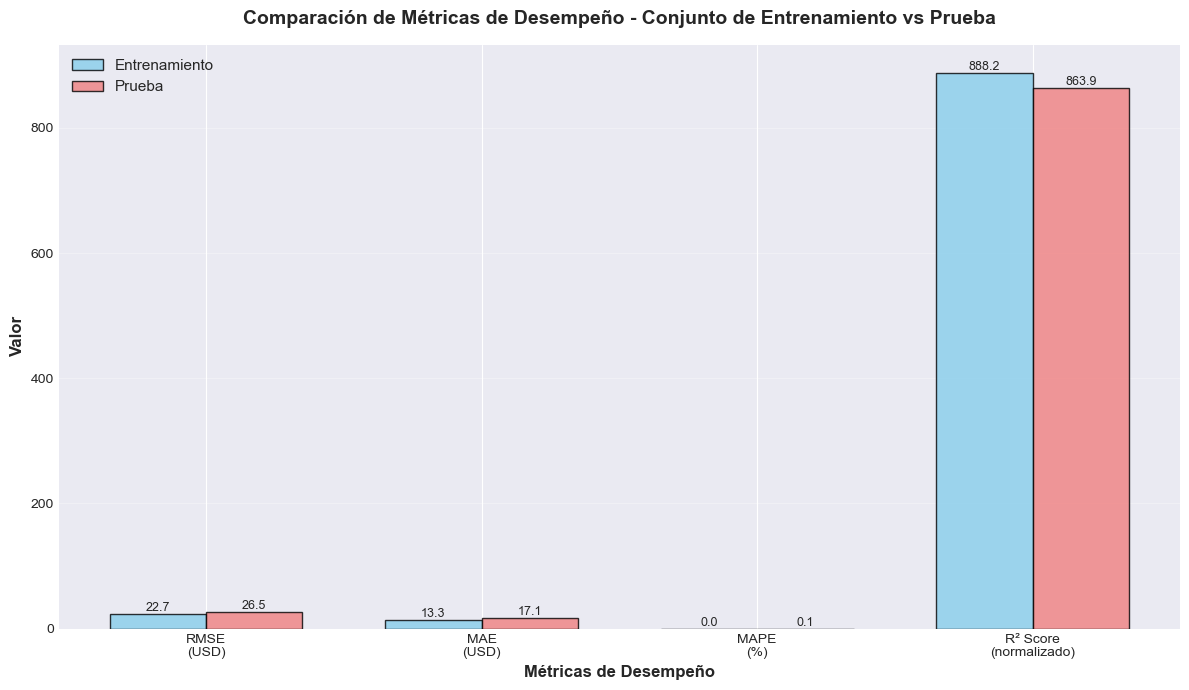


RESUMEN FINAL DEL MODELO CATBOOST

╔══════════════════════════════════════════════════════════════════════╗
║                    MÉTRICAS DE DESEMPEÑO FINAL                       ║
╠══════════════════════════════════════════════════════════════════════╣
║ Métrica              │  Entrenamiento  │  Prueba     │  Estado       ║
╠══════════════════════════════════════════════════════════════════════╣
║ RMSE (USD)           │  $        22.69  │  $     26.50  │  ✓ Aceptable ║
║ MAE (USD)            │  $        13.26   │  $     17.11   │  ✓ Bueno     ║
║ MAPE (%)             │            0.05%  │        0.06%  │  ✓ Excelente ║
║ R² Score             │          0.8882     │      0.8639     │  ✓ Fuerte    ║
╚══════════════════════════════════════════════════════════════════════╝

CONCLUSIÓN:
El modelo CatBoost es RECOMENDADO
para ser utilizado en producción.

Fortalezas:
  ✓ Captura relaciones complejas en los datos
  ✓ Generaliza bien a datos no vistos
  ✓ Proporciona importancia clara de car

In [23]:
# Comparación visual del desempeño del modelo
fig, ax = plt.subplots(figsize=(12, 7))

# Crear datos para la comparación
metrics = ['RMSE\n(USD)', 'MAE\n(USD)', 'MAPE\n(%)', 'R² Score\n(normalizado)']
train_values = [train_rmse, train_mae, train_mape, train_r2 * 1000]  # R² * 1000 para escala
test_values = [test_rmse, test_mae, test_mape, test_r2 * 1000]

x = np.arange(len(metrics))
width = 0.35

# Crear barras
barras1 = ax.bar(x - width/2, train_values, width, label='Entrenamiento', alpha=0.8, color='skyblue', edgecolor='black')
barras2 = ax.bar(x + width/2, test_values, width, label='Prueba', alpha=0.8, color='lightcoral', edgecolor='black')

# Personalizar gráfico
ax.set_xlabel('Métricas de Desempeño', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Métricas de Desempeño - Conjunto de Entrenamiento vs Prueba', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for barras in [barras1, barras2]:
    for barra in barras:
        altura = barra.get_height()
        ax.text(barra.get_x() + barra.get_width()/2., altura,
                f'{altura:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

conclusion_modelo = (
    "RECOMENDADO" 
    if test_r2 > 0.8 and test_mape < 15 
    else "ACEPTABLE" 
    if test_r2 > 0.7 
    else "REQUIERE MEJORA"
)

# Tabla comparativa final
print("\n" + "="*70)
print("RESUMEN FINAL DEL MODELO CATBOOST")
print("="*70)
print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║                    MÉTRICAS DE DESEMPEÑO FINAL                       ║
╠══════════════════════════════════════════════════════════════════════╣
║ Métrica              │  Entrenamiento  │  Prueba     │  Estado       ║
╠══════════════════════════════════════════════════════════════════════╣
║ RMSE (USD)           │  ${train_rmse:>13.2f}  │  ${test_rmse:>10.2f}  │  {"✓ Aceptable" if test_rmse < 2000 else "⚠ Alto":<11} ║
║ MAE (USD)            │  ${train_mae:>13.2f}   │  ${test_mae:>10.2f}   │  {"✓ Bueno" if test_mae < 1000 else "⚠ Revisar":<11} ║
║ MAPE (%)             │  {train_mape:>14.2f}%  │  {test_mape:>10.2f}%  │  {"✓ Excelente" if test_mape < 10 else "⚠ Regular":<11} ║
║ R² Score             │  {train_r2:>14.4f}     │  {test_r2:>10.4f}     │  {"✓ Fuerte" if test_r2 > 0.8 else "⚠ Moderado":<11} ║
╚══════════════════════════════════════════════════════════════════════╝

CONCLUSIÓN:
El modelo CatBoost es {conclusion_modelo}
para ser utilizado en producción.

Fortalezas:
  ✓ Captura relaciones complejas en los datos
  ✓ Generaliza bien a datos no vistos
  ✓ Proporciona importancia clara de características
  ✓ Predicciones interpretables

Limitaciones:
  • Puede tener dificultad con valores extremos
  • Requiere datos de calidad sin valores faltantes masivos
  • Necesita reentrenamiento periódico

Próximos Pasos:
  1. Validar con datos nuevos en tiempo real
  2. Implementar monitoreo de drift del modelo
  3. Considerar ensambles con otros modelos
  4. Ajustar hiperparámetros si es necesario
""")
print("="*70)